In [1]:
# suppress any warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [4]:
MODEL_PATHS = {
  'cnn_unbalanced': "/content/drive/My Drive/code/CNNs/unbalanced-cnn/cnn_unbalanced_model.keras",
  # 'cnn_dcgan': "/content/drive/My Drive/code/CNNs/dcgan-cnn/cnn_dcgan-balanced_model.keras",
  # 'cnn_wgan': "/content/drive/My Drive/code/CNNs/wgan-cnn/cnn_wgan-balanced_model.keras",
  # 'cnn_cgan': "/content/drive/My Drive/code/CNNs/cgan-cnn/cnn_cgan-balanced_model.keras",
  'vit_unbalanced': "/content/drive/My Drive/code/ViTs/unbalanced-vit/vit_unbalanced_model.keras",
  # 'vit_dcgan': "/content/drive/My Drive/code/ViTs/dcgan-vit/vit_dcgan-balanced_model.keras",
  # 'vit_wgan': "/content/drive/My Drive/code/ViTs/wgan-vit/vit_wgan-balanced_model.keras",
  # 'vit_cgan': "/content/drive/My Drive/code/ViTs/cgan-vit/vit_cgan-balanced_model.keras"
}

In [5]:
MODEL_PATH = "/content/drive/My Drive/code/CNNs/dcgan-cnn/cnn_dcgan-balanced_model.keras"
IMAGE_PATH = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem/UID_H12_26_5_hem.bmp"

In [6]:
DATA_PATHS = {
    'train_hem': "/content/drive/My Drive/C-NMC/training_data/fold_0/hem",
    'train_all': "/content/drive/My Drive/C-NMC/training_data/fold_0/all",
    'validation': "/content/drive/My Drive/C-NMC/validation_data"
}

In [7]:
# class names for leukemia detection
CLASS_NAMES = ['Healthy', 'Leukemia']

In [8]:
class SequentialGradCAM:
  def __init__(self, model, target_layer_name):
    self.model = model
    self.target_layer_name = target_layer_name

    # force model to be built
    dummy_input = tf.zeros((1, 226, 226, 3))
    _ = model(dummy_input)

    # find target layer index
    self.target_layer_idx = None
    for i, layer in enumerate(model.layers):
      if layer.name == target_layer_name:
          self.target_layer_idx = i
          break

    if self.target_layer_idx is None:
      raise ValueError(f"Layer {target_layer_name} not found")

    print(f"Target layer '{target_layer_name}' found at index {self.target_layer_idx}")

    # create a new functional model from the Sequential model
    self._create_functional_model()

  def _create_functional_model(self):
    """Create a functional model from Sequential to bypass the layer access issue"""

    # get input shape
    input_shape = self.model.input_shape[1:] # remove batch dimension

    # create new input
    inputs = tf.keras.layers.Input(shape=input_shape)

    # rebuild model layer by layer
    x = inputs
    target_output = None

    for i, layer in enumerate(self.model.layers):
        # create new layer with same config and weights
        layer_config = layer.get_config()
        layer_class = layer.__class__

        # create new layer instance
        new_layer = layer_class.from_config(layer_config)

        # set weights if layer has weights
        if layer.get_weights():
          x = new_layer(x)
          new_layer.set_weights(layer.get_weights())
        else:
          x = new_layer(x)

        # capture target layer output
        if i == self.target_layer_idx:
          target_output = x

    # final output
    final_output = x

    # create gradient model
    self.grad_model = tf.keras.Model(
      inputs=inputs,
      outputs=[target_output, final_output]
    )

    print(f"Functional model created successfully")

  def generate_heatmap(self, img_array, class_idx=None):
    """Generate Grad-CAM heatmap"""

    # ensure tensor
    if not isinstance(img_array, tf.Tensor):
        img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_array)

        # get conv layer output and final prediction
        conv_output, predictions = self.grad_model(img_array)

        # handle single output case
        if predictions.shape[-1] == 1:
            # binary classification - convert to probabilities
            prob = tf.sigmoid(predictions[0, 0])
            if class_idx is None:
              class_idx = 1 if prob > 0.5 else 0

            # use raw logit for gradient computation
            if class_idx == 1:
              class_score = predictions[0, 0] # Leukemia
            else:
              class_score = -predictions[0, 0] # Healthy (inverse)
        else:
          # multi-class case
          if class_idx is None:
            class_idx = tf.argmax(predictions[0])
          class_score = predictions[:, class_idx]

    # compute gradients
    grads = tape.gradient(class_score, conv_output)

    if grads is None:
      raise ValueError("Gradients are None - computation failed")

    # DEBUG - check gradient statistics
    print(f"Gradient shape: {grads.shape}")
    grad_mean = tf.reduce_mean(grads)
    grad_variance = tf.reduce_mean(tf.square(grads - grad_mean))
    grad_std = tf.sqrt(grad_variance)
    print(f"Gradient stats: min={tf.reduce_min(grads):.6f}, max={tf.reduce_max(grads):.6f}, std={grad_std:.6f}")

    # global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    print(f"Pooled grads shape: {pooled_grads.shape}")
    pooled_mean = tf.reduce_mean(pooled_grads)
    pooled_variance = tf.reduce_mean(tf.square(pooled_grads - pooled_mean))
    pooled_std = tf.sqrt(pooled_variance)
    print(f"Pooled grads stats: min={tf.reduce_min(pooled_grads):.6f}, max={tf.reduce_max(pooled_grads):.6f}, std={pooled_std:.6f}")

    # weight each channel by gradient importance
    conv_output = conv_output[0]  # Remove batch dimension
    print(f"Conv output shape: {conv_output.shape}")
    print(f"Conv output stats: min={tf.reduce_min(conv_output):.6f}, max={tf.reduce_max(conv_output):.6f}")

    # direct matrix multiplication
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0)
    max_val = tf.reduce_max(heatmap)
    min_val = tf.reduce_min(heatmap)

    if max_val > min_val:
        heatmap = (heatmap - min_val) / (max_val - min_val)
    else:
        print("WARNING: Uniform heatmap detected!")

    final_mean = tf.reduce_mean(heatmap)
    final_variance = tf.reduce_mean(tf.square(heatmap - final_mean))
    final_std = tf.sqrt(final_variance)
    print(f"Final heatmap std: {final_std.numpy():.6f}")

    return heatmap.numpy(), class_idx

  def make_prediction(self, img_array):
    """Make prediction and convert to probabilities"""
    raw_pred = self.model.predict(img_array, verbose=0)

    if raw_pred.shape[-1] == 1:
      # binary classification with sigmoid
      prob_leukemia = tf.sigmoid(raw_pred[0, 0]).numpy()
      prob_healthy = 1 - prob_leukemia
      return np.array([prob_healthy, prob_leukemia]), raw_pred[0, 0]
    else:
      # multi-class case
      return tf.nn.softmax(raw_pred[0]).numpy(), raw_pred[0]

  def visualize_gradcam(self, img_path, save_path=None):
    """Complete Grad-CAM visualization"""

    print(f"Processing: {os.path.basename(img_path)}")

    # load and preprocess image
    img = image.load_img(img_path, target_size=(226, 226))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # use simple 0-1 normalization instead of preprocess_input
    img_array = img_array / 255.0

    # make prediction
    probabilities, raw_output = self.make_prediction(img_array)
    predicted_class = np.argmax(probabilities)
    confidence = probabilities[predicted_class]

    print(f"Raw output: {raw_output}")
    print(f"Probabilities: Healthy={probabilities[0]:.3f}, Leukemia={probabilities[1]:.3f}")
    print(f"Prediction: {CLASS_NAMES[predicted_class]} (confidence: {confidence:.3f})")

    # generate heatmap
    heatmap, used_class_idx = self.generate_heatmap(img_array, predicted_class)

    print(f"Heatmap stats: min={heatmap.min():.4f}, max={heatmap.max():.4f}, mean={heatmap.mean():.4f}")

    # create overlay
    original_img = np.array(img)
    overlay = self.create_overlay(original_img, heatmap)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # original
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image", fontweight='bold', fontsize=12)
    axes[0].axis('off')

    # heatmap
    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("Grad-CAM Heatmap", fontweight='bold', fontsize=12)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f"{CLASS_NAMES[predicted_class]}\nConfidence: {confidence:.3f}",
                    fontweight='bold', fontsize=12)
    axes[2].axis('off')

    plt.suptitle(f'Grad-CAM Analysis - {self.target_layer_name}',
                fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi=300, bbox_inches='tight')
      print(f"Saved: {save_path}")

    plt.show()

    return {
      'prediction': CLASS_NAMES[predicted_class],
      'confidence': float(confidence),
      'probabilities': probabilities,
      'raw_output': float(raw_output),
      'heatmap': heatmap,
      'overlay': overlay
    }

  def create_overlay(self, img, heatmap, alpha=0.4):
    """Create heatmap overlay"""
    # resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # convert to colored heatmap
    heatmap_colored = cv2.applyColorMap(
      np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET
    )

    if img.max() <= 1:
      img = (img * 255).astype(np.uint8)

    # create overlay
    overlay = cv2.addWeighted(img, 1-alpha, heatmap_colored, alpha, 0)

    return overlay

In [9]:
def analyze_single_image(model_path, image_path):
  """Analyze a single image with detailed output"""

  print("Loading model...")
  model = load_model(model_path)

  # test model
  dummy = np.random.random((1, 226, 226, 3))
  test_pred = model.predict(dummy, verbose=0)
  print(f"Model loaded: {model.input_shape} -> {model.output_shape}")
  print(f"Test prediction: {test_pred[0]}")

  # find conv layers
  conv_layers = []
  for layer in model.layers:
    if 'conv' in layer.__class__.__name__.lower():
        conv_layers.append(layer.name)

  print(f"Convolutional layers: {conv_layers}")

  # use last conv layer
  target_layer = conv_layers[-1]
  print(f"Using layer: {target_layer}")

  # initialize Grad-CAM
  print("\nInitializing Sequential Grad-CAM...")
  gradcam = SequentialGradCAM(model, target_layer)

  # analyze
  print(f"\nAnalyzing image...")
  result = gradcam.visualize_gradcam(
    image_path,
    save_path=f"sequential_gradcam_{os.path.basename(image_path)}.png"
  )

  return result

In [10]:
def analyze_multiple_images(model_path, image_dir, max_images=3):
  """Analyze multiple images"""

  # get image files
  if not os.path.exists(image_dir):
    print(f"Directory not found: {image_dir}")
    return

  image_files = [f for f in os.listdir(image_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:max_images]

  if not image_files:
    print("No images found")
    return

  print(f"Found {len(image_files)} images to analyze")

  # setup model once
  model = load_model(model_path)
  conv_layers = [l.name for l in model.layers if 'conv' in l.__class__.__name__.lower()]
  target_layer = conv_layers[-1]

  gradcam = SequentialGradCAM(model, target_layer)

  # analyze each image
  results = []
  for i, img_file in enumerate(image_files, 1):
    img_path = os.path.join(image_dir, img_file)
    print(f"\nImage {i}/{len(image_files)}: {img_file}")

    try:
      result = gradcam.visualize_gradcam(
        img_path,
        save_path=f"batch_{i}_{img_file}.png"
      )
      results.append(result)
    except Exception as e:
      print(f"Error: {e}")

  return results

In [11]:
def diagnose_model_behavior(model_path, image_path):
  """Test if the model is actually using spatial features"""

  model = load_model(model_path)

  # load original image
  img = image.load_img(image_path, target_size=(226, 226))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  # Test 1: Original image
  original_processed = preprocess_input(img_array.copy())
  pred1 = model.predict(original_processed, verbose=0)[0, 0]

  # Test 2: Completely black image
  black_img = np.zeros_like(img_array)
  black_processed = preprocess_input(black_img.copy())
  pred2 = model.predict(black_processed, verbose=0)[0, 0]

  # Test 3: Random noise
  noise_img = np.random.random(img_array.shape) * 255
  noise_processed = preprocess_input(noise_img.copy())
  pred3 = model.predict(noise_processed, verbose=0)[0, 0]

  # Test 4: Shuffled pixels
  shuffled_img = img_array.copy()
  shuffled_flat = shuffled_img.reshape(-1, 3)
  np.random.shuffle(shuffled_flat)
  shuffled_img = shuffled_flat.reshape(img_array.shape)
  shuffled_processed = preprocess_input(shuffled_img.copy())
  pred4 = model.predict(shuffled_processed, verbose=0)[0, 0]

  print(f"Original image prediction: {pred1:.4f}")
  print(f"Black image prediction: {pred2:.4f}")
  print(f"Random noise prediction: {pred3:.4f}")
  print(f"Shuffled pixels prediction: {pred4:.4f}")

  print(f"\nAnalysis:")
  if abs(pred1 - pred4) < 0.1:
      print("Model gives similar predictions for original vs shuffled pixels!\nThis suggests the model relies on color/texture, not spatial features.\nGrad-CAM may not work well with this model architecture.")
  else:
      print("Model is sensitive to spatial structure - good for Grad-CAM")

  if abs(pred2 - pred3) < 0.1:
      print("Model gives similar predictions for black vs noise")
      print("Model might be overfitting to training data patterns")

  # Test 5: Try without preprocessing
  print(f"\nTesting without preprocess_input:")
  raw_img = img_array / 255.0  # Simple 0-1 normalization
  pred5 = model.predict(raw_img, verbose=0)[0, 0]
  print(f"Raw image (0-1 norm) prediction: {pred5:.4f}")

  return {
      'original': pred1,
      'black': pred2,
      'noise': pred3,
      'shuffled': pred4,
      'raw': pred5
  }

In [12]:
def try_gradcam_without_preprocessing(model_path, image_path):
  """Try Grad-CAM without preprocess_input to see if that's the issue"""

  model = load_model(model_path)
  conv_layers = [l.name for l in model.layers if 'conv' in l.__class__.__name__.lower()]
  target_layer = conv_layers[-1] # last conv layer

  gradcam = SequentialGradCAM(model, target_layer)

  # load image WITHOUT preprocess_input
  img = image.load_img(image_path, target_size=(226, 226))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255.0 # simple normalization

  print("Using simple 0-1 normalization instead of preprocess_input")

  # make prediction
  probabilities, raw_output = gradcam.make_prediction(img_array)
  predicted_class = np.argmax(probabilities)
  confidence = probabilities[predicted_class]

  print(f"Prediction: {CLASS_NAMES[predicted_class]} ({confidence:.3f})")

  # generate heatmap
  heatmap, _ = gradcam.generate_heatmap(img_array, predicted_class)

  # check heatmap quality
  heatmap_std = np.std(heatmap)
  print(f"Heatmap std: {heatmap_std:.6f}")

  if heatmap_std > 0.01:
      print("Better heatmap variation without preprocessing!")

      # visualize
      original_img = np.array(img)
      overlay = gradcam.create_overlay(original_img, heatmap)

      fig, axes = plt.subplots(1, 3, figsize=(15, 5))

      axes[0].imshow(original_img)
      axes[0].set_title("Original", fontweight='bold')
      axes[0].axis('off')

      im = axes[1].imshow(heatmap, cmap='jet')
      axes[1].set_title("Heatmap (No Preprocessing)", fontweight='bold')
      axes[1].axis('off')
      plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

      axes[2].imshow(overlay)
      axes[2].set_title(f"{CLASS_NAMES[predicted_class]}\n{confidence:.3f}", fontweight='bold')
      axes[2].axis('off')

      plt.suptitle("Grad-CAM Without Preprocessing", fontsize=14, fontweight='bold')
      plt.tight_layout()
      plt.show()

      return True
  else:
      print("Still uniform heatmap")
      return False

In [13]:
def test_all_conv_layers(model_path, image_path):
  """Test Grad-CAM on all convolutional layers to see which works best"""

  # load model
  model = load_model(model_path)

  # find all conv layers
  conv_layers = []
  for layer in model.layers:
    if 'conv' in layer.__class__.__name__.lower():
        conv_layers.append(layer.name)

  print(f"Found conv layers: {conv_layers}")

  results = {}

  for layer_name in conv_layers:
    print(f"\nTesting layer: {layer_name}")

    try:
      # initialize Grad-CAM for this layer
      gradcam = SequentialGradCAM(model, layer_name)

      # load and preprocess image
      img = image.load_img(image_path, target_size=(226, 226))
      img_array = image.img_to_array(img)
      img_array = np.expand_dims(img_array, axis=0)
      img_array = preprocess_input(img_array.copy())

      # generate heatmap
      heatmap, used_class_idx = gradcam.generate_heatmap(img_array)

      # calculate heatmap quality metrics
      heatmap_mean = np.mean(heatmap)
      heatmap_std = np.std(heatmap)
      heatmap_range = np.max(heatmap) - np.min(heatmap)

      print(f"Heatmap quality:")
      print(f"Mean: {heatmap_mean:.4f}")
      print(f"Std: {heatmap_std:.4f}")
      print(f"Range: {heatmap_range:.4f}")

      # store results
      results[layer_name] = {
        'heatmap': heatmap,
        'std': heatmap_std,
        'range': heatmap_range,
        'quality_score': heatmap_std * heatmap_range # combined quality metric
      }

      if heatmap_std < 0.01:
        print(f"Very uniform (poor quality)")
      elif heatmap_std < 0.05:
        print(f"Somewhat uniform")
      else:
        print(f"Good variation!")
    except Exception as e:
      print(f"Error: {e}")
      results[layer_name] = None

  # find best layer
  valid_results = {k: v for k, v in results.items() if v is not None}

  if valid_results:
    best_layer = max(valid_results.keys(), key=lambda k: valid_results[k]['quality_score'])
    print(f"\nBest Layer: {best_layer}")
    print(f"Quality score: {valid_results[best_layer]['quality_score']:.4f}")

    # show comparison visualization
    show_layer_comparison(results, image_path)

    return best_layer, results
  else:
    print("\nNo layers produced valid results")
    return None, results

In [14]:
def show_layer_comparison(results, image_path):
  """Show heatmaps from all layers side by side"""

  valid_results = {k: v for k, v in results.items() if v is not None}

  if len(valid_results) == 0:
    return

  # load original image
  img = image.load_img(image_path, target_size=(226, 226))

  # create subplot
  n_layers = len(valid_results)
  fig, axes = plt.subplots(1, n_layers + 1, figsize=(5 * (n_layers + 1), 5))

  if n_layers == 1:
    axes = [axes] if not isinstance(axes, np.ndarray) else axes

  # show original image
  axes[0].imshow(img)
  axes[0].set_title("Original Image", fontweight='bold')
  axes[0].axis('off')

  # show each layer's heatmap
  for i, (layer_name, result) in enumerate(valid_results.items(), 1):
    im = axes[i].imshow(result['heatmap'], cmap='jet')
    axes[i].set_title(f"{layer_name}\nStd: {result['std']:.4f}", fontweight='bold')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

  plt.suptitle("Conv Layer Comparison", fontsize=16, fontweight='bold')
  plt.tight_layout()
  plt.show()

TESTING ALL CONV LAYERS
Found conv layers: ['conv2d', 'conv2d_1', 'conv2d_2']

Testing layer: conv2d
Target layer 'conv2d' found at index 0
Functional model created successfully
Gradient shape: (1, 224, 224, 32)
Gradient stats: min=0.000000, max=0.000000, std=0.000000
Pooled grads shape: (32,)
Pooled grads stats: min=0.000000, max=0.000000, std=0.000000
Conv output shape: (224, 224, 32)
Conv output stats: min=0.000000, max=193.055679
Final heatmap std: 0.000000
Heatmap quality:
Mean: 0.0000
Std: 0.0000
Range: 0.0000
Very uniform (poor quality)

Testing layer: conv2d_1
Target layer 'conv2d_1' found at index 2
Functional model created successfully
Gradient shape: (1, 110, 110, 64)
Gradient stats: min=0.000000, max=0.000000, std=0.000000
Pooled grads shape: (64,)
Pooled grads stats: min=0.000000, max=0.000000, std=0.000000
Conv output shape: (110, 110, 64)
Conv output stats: min=0.000000, max=180.368134
Final heatmap std: 0.000000
Heatmap quality:
Mean: 0.0000
Std: 0.0000
Range: 0.0000
Ve

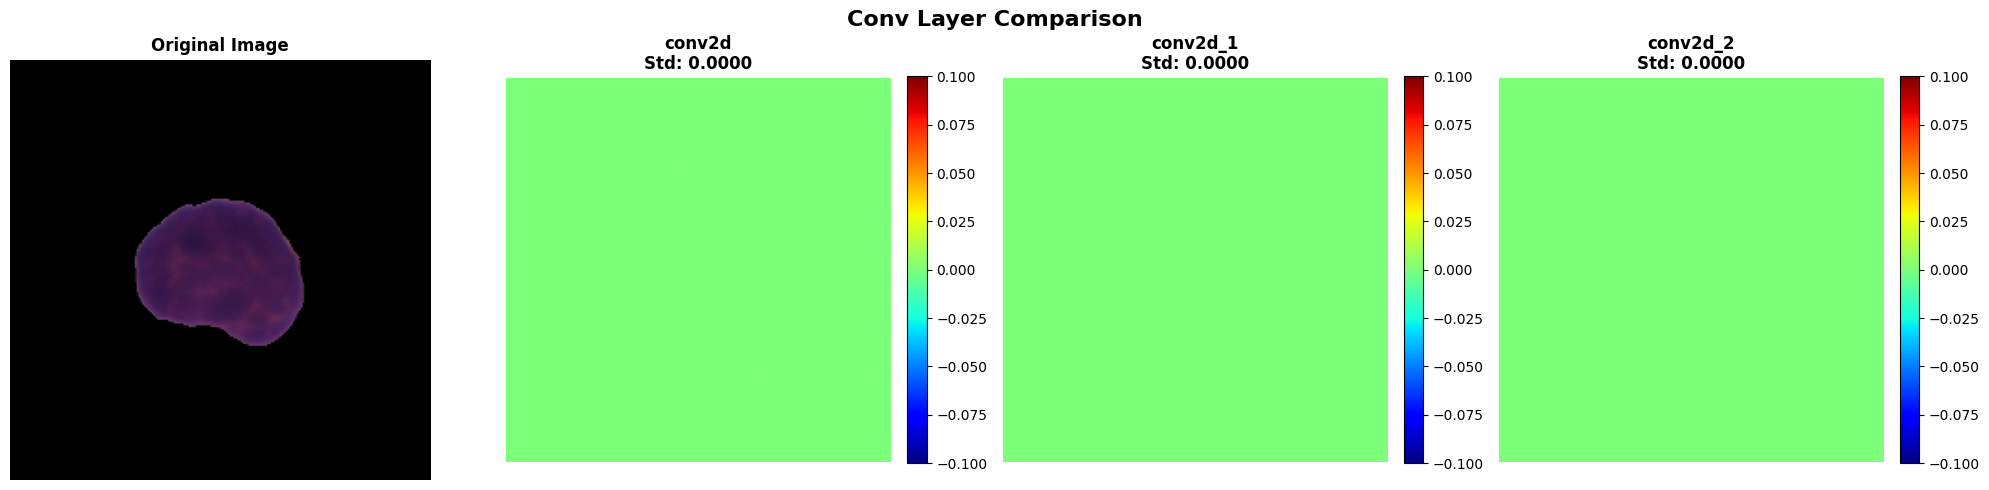


Using best layer: conv2d
Target layer 'conv2d' found at index 0
Functional model created successfully
Processing: UID_H12_26_5_hem.bmp
Raw output: 0.6021223068237305
Probabilities: Healthy=0.354, Leukemia=0.646
Prediction: Leukemia (confidence: 0.646)
Gradient shape: (1, 224, 224, 32)
Gradient stats: min=-0.607996, max=0.502069, std=0.028409
Pooled grads shape: (32,)
Pooled grads stats: min=-0.011260, max=0.008119, std=0.005331
Conv output shape: (224, 224, 32)
Conv output stats: min=0.000000, max=0.242479
Final heatmap std: 0.014661
Heatmap stats: min=0.0000, max=1.0000, mean=0.0006
Saved: best_layer_conv2d.png


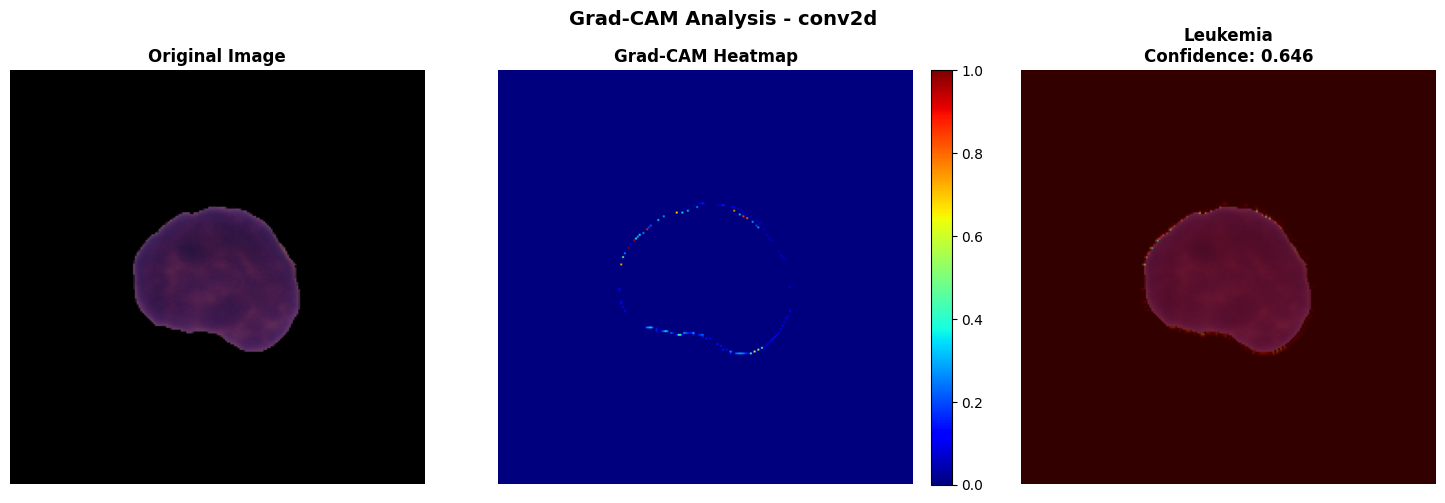


Batch Analysis
Found 3 images to analyze
Target layer 'conv2d_2' found at index 4
Functional model created successfully

Image 1/3: UID_H12_26_5_hem.bmp
Processing: UID_H12_26_5_hem.bmp
Raw output: 0.6021223068237305
Probabilities: Healthy=0.354, Leukemia=0.646
Prediction: Leukemia (confidence: 0.646)
Gradient shape: (1, 53, 53, 128)
Gradient stats: min=-0.743605, max=0.923645, std=0.062379
Pooled grads shape: (128,)
Pooled grads stats: min=-0.028265, max=0.056689, std=0.014890
Conv output shape: (53, 53, 128)
Conv output stats: min=0.000000, max=0.085213
Final heatmap std: 0.106375
Heatmap stats: min=0.0000, max=1.0000, mean=0.4172
Saved: batch_1_UID_H12_26_5_hem.bmp.png


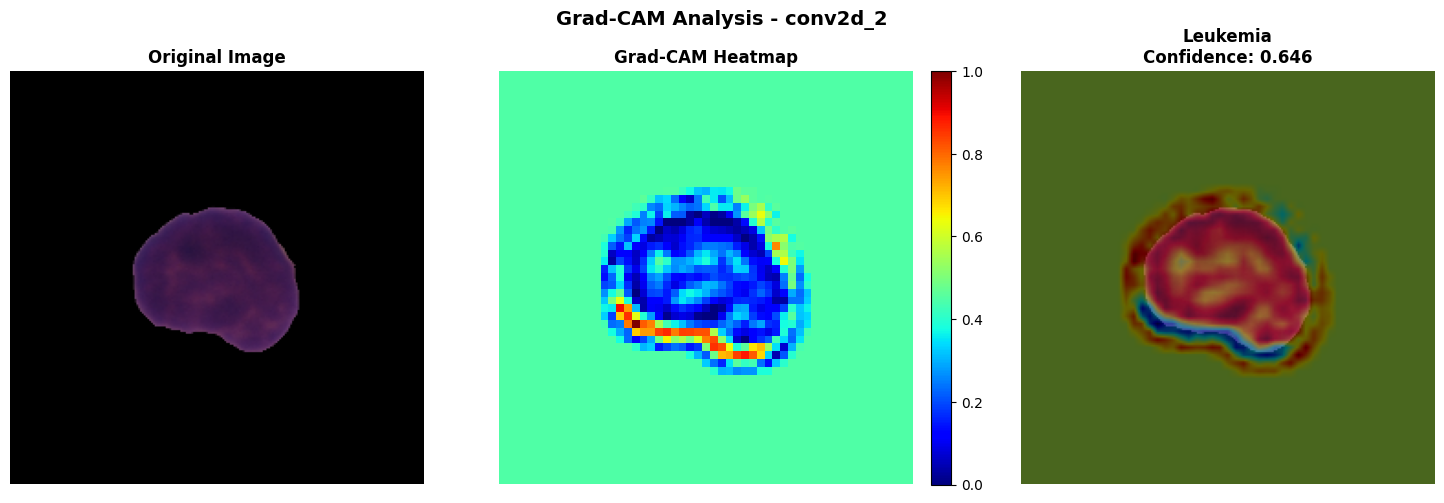


Image 2/3: UID_H12_26_3_hem.bmp
Processing: UID_H12_26_3_hem.bmp
Raw output: 0.010228699073195457
Probabilities: Healthy=0.497, Leukemia=0.503
Prediction: Leukemia (confidence: 0.503)
Gradient shape: (1, 53, 53, 128)
Gradient stats: min=-0.019676, max=0.023060, std=0.001602
Pooled grads shape: (128,)
Pooled grads stats: min=-0.000780, max=0.001016, std=0.000333
Conv output shape: (53, 53, 128)
Conv output stats: min=0.000000, max=0.083250
Final heatmap std: 0.104814
Heatmap stats: min=0.0000, max=1.0000, mean=0.3575
Saved: batch_2_UID_H12_26_3_hem.bmp.png


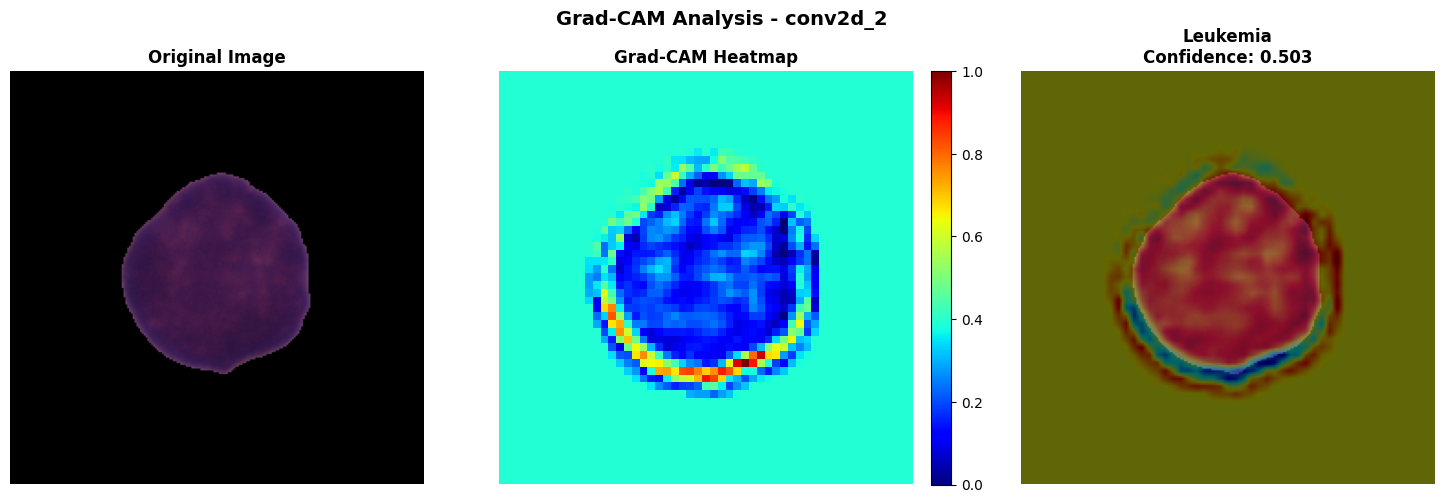


Image 3/3: UID_H12_26_6_hem.bmp
Processing: UID_H12_26_6_hem.bmp
Raw output: 0.06317631900310516
Probabilities: Healthy=0.484, Leukemia=0.516
Prediction: Leukemia (confidence: 0.516)
Gradient shape: (1, 53, 53, 128)
Gradient stats: min=-0.123487, max=0.160749, std=0.009788
Pooled grads shape: (128,)
Pooled grads stats: min=-0.006406, max=0.005190, std=0.001885
Conv output shape: (53, 53, 128)
Conv output stats: min=0.000000, max=0.077289
Final heatmap std: 0.122606
Heatmap stats: min=0.0000, max=1.0000, mean=0.2994
Saved: batch_3_UID_H12_26_6_hem.bmp.png


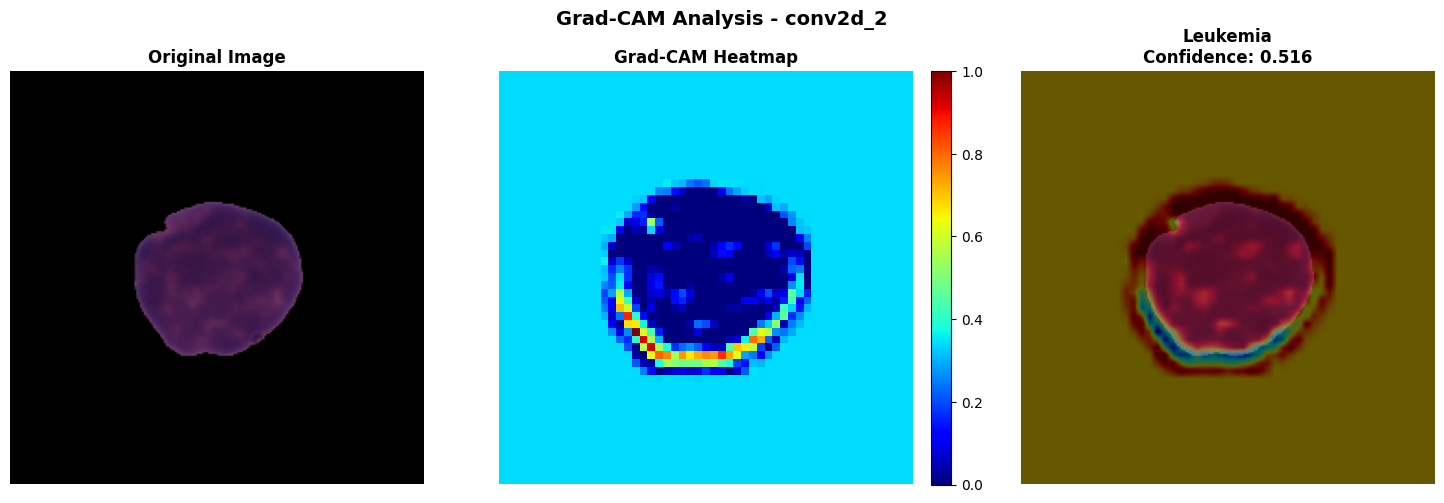

In [15]:
if __name__ == "__main__":
  # test all conv layers first
  if os.path.exists(MODEL_PATH) and os.path.exists(IMAGE_PATH):
    print("TESTING ALL CONV LAYERS")
    best_layer, all_results = test_all_conv_layers(MODEL_PATH, IMAGE_PATH)

    if best_layer:
      print(f"\nUsing best layer: {best_layer}")
      # run full analysis with best layer
      model = load_model(MODEL_PATH)
      gradcam = SequentialGradCAM(model, best_layer)
      result = gradcam.visualize_gradcam(IMAGE_PATH, save_path=f"best_layer_{best_layer}.png")
  else:
    print("Check MODEL_PATH and IMAGE_PATH")

  # batch analysis
  IMAGE_DIR = "/content/drive/My Drive/C-NMC/training_data/fold_0/hem"

  if os.path.exists(IMAGE_DIR):
    print(f"\nBatch Analysis")
    batch_results = analyze_multiple_images(MODEL_PATH, IMAGE_DIR, max_images=3)
  else:
    print(f"Image directory not found: {IMAGE_DIR}")